#ELEN 6885 Reinforcement Learning Coding Assignment (Part 4)#
There are a lot of official and unofficial tutorials about Tensorflow, and there are also many open-source projects written in Tensorflow. You can refer to those resources according to your interest. In this part of homework 4, only knowledge of Deep Reinforcement Learning and basic programming skills will be needed.

Please put your code into the block marked by\
\############################\
\# YOUR CODE STARTS HERE\
\# YOUR CODE ENDS HERE\
\############################\
Normally you don't need to edit anything outside of the block. If you do want to edit something, please use a similar manner to mark you edits.


Blank 1: you are supposed to complete building the target net.

Blank 2: you are supposed to complete the calculation of the q target.

Blank 3: you are supposed to complete the training process. More specifically, you will need to reset the environment after each episode, calculate episode length, calculate and take action, observe and store transition into memory.

Blank 4: you are supposed to let the trained agent play the game 100 times and print out how long can the agent play for each time. Codes will be similar to those of blank 3.

In [0]:
import numpy as np
import tensorflow as tf

# DQN
class DQN:
  def __init__(
      self,
      actions_num,
      state_size,
      learning_rate = 0.001,
      gamma = 0.99,
      epsilon_min = 0.05,
      epsilon_start = 0.9,
      replace_target_iter = 300,
      memory_size = 500,
      batch_size = 2,
      epsilon_increment = None,
  ):
      self.actions_num = actions_num
      self.state_size = state_size
      self.lr = learning_rate
      self.gamma = gamma
      self.epsilon_min = epsilon_min
      self.replace_target_iter = replace_target_iter
      self.memory_size = memory_size
      self.batch_size = batch_size
      self.epsilon_increment = epsilon_increment
      self.epsilon = epsilon_start if epsilon_increment is not None else self.epsilon_min
      self.save_model_path = './weights/DQN_model.ckpt'
      self.memory_counter = 0

      # learned steps counter
      self.steps_counter = 0

      # initialize memory [s, a, r, s_, done]
      self.memory = np.zeros((self.memory_size, state_size * 2 + 3))

      # build target_net and q_net
      self.build_net()
      t_params = tf.get_collection('target_net_params')
      q_params = tf.get_collection('q_net_params')
      self.replace_target = [tf.assign(t, q) for t, q in zip(t_params, q_params)]

      # gpu setting
      config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
      config.gpu_options.per_process_gpu_memory_fraction = 0.6
      self.sess = tf.Session(config=config)

      self.sess.run(tf.global_variables_initializer())

  def build_net(self):
    # build q_net
    self.state = tf.placeholder(tf.float32, [None, self.state_size], name='state')
    self.q_target = tf.placeholder(tf.float32, [None, self.actions_num], name='Q_target')
    with tf.variable_scope('q_net'):
      # c_names(collections_names) are the collections to store variables
      c_names, neurons_layer_1, w_initializer, b_initializer = \
        ['q_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 100, \
        tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

      # layer 1
      with tf.variable_scope('layer_1'):
        w_layer_1 = tf.get_variable('w_layer_1', [self.state_size, neurons_layer_1], initializer=w_initializer, collections=c_names)
        b_layer_1 = tf.get_variable('b_layer_1', [1, neurons_layer_1], initializer=b_initializer, collections=c_names)
        layer_1 = tf.nn.relu(tf.matmul(self.state, w_layer_1) + b_layer_1)

      # layer 2
      with tf.variable_scope('layer_2'):
        w_layer_2 = tf.get_variable('w_layer_2', [neurons_layer_1, self.actions_num], initializer=w_initializer, collections=c_names)
        b_layer_2 = tf.get_variable('b_layer_2', [1, self.actions_num], initializer=b_initializer, collections=c_names)
        self.q_value = tf.matmul(layer_1, w_layer_2) + b_layer_2

    with tf.variable_scope('loss'):
      self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_value))
    with tf.variable_scope('train'):
      self._train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)

    # build target_net
    self.state_t = tf.placeholder(tf.float32, [None, self.state_size], name='state_t')    # input
    with tf.variable_scope('target_net'):
      # c_names(collections_names) are the collections to store variables
      c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

      # layer 1
      with tf.variable_scope('layer_1'):
        w_layer_1 = tf.get_variable('w_layer_1', [self.state_size, neurons_layer_1], initializer=w_initializer, collections=c_names)
        b_layer_1 = tf.get_variable('b_layer_1', [1, neurons_layer_1], initializer=b_initializer, collections=c_names)
        layer_1 = tf.nn.relu(tf.matmul(self.state_t, w_layer_1) + b_layer_1)

      # layer 2

      ############################
      # YOUR CODE STARTS HERE
      # "self.q_next" should be defined by you in the first blank where you are required to complete building the target net.
      #Note that q_next (Q(s’, a’)) is the q value given by the target network while R + Q(s’, a’) is the q_target. 
      # YOUR CODE ENDS HERE
        
      with tf.variable_scope('layer_2'):
        w_layer_2 = tf.get_variable('w_layer_2', [neurons_layer_1, self.actions_num], initializer=w_initializer, collections=c_names)
        b_layer_2 = tf.get_variable('b_layer_2', [1, self.actions_num], initializer=b_initializer, collections=c_names)
        self.q_next = tf.matmul(layer_1, w_layer_2) + b_layer_2


      ############################
     
  def store_transition(self, s, a, r, s_, done):
    s=s.reshape(-1)
    s_=s_.reshape(-1)
    transition = np.hstack((s, [a, r], s_, done))

    # replace the old memory with new observations
    index = self.memory_counter % self.memory_size
    self.memory[index, :] = transition

    self.memory_counter += 1

  def choose_action(self, observation):
    # to have batch dimension when fed into tf placeholder
    observation = observation[np.newaxis, :]
    # epsilon-greedy
    if np.random.uniform() > self.epsilon:
      action_values = self.sess.run(self.q_value, feed_dict={self.state: observation})
      action = np.argmax(action_values)
    else:
      action = np.random.randint(0, self.actions_num)
    return action

  def learn(self):
    # replace target parameters every once a while
    if self.steps_counter % self.replace_target_iter == 0:
      self.sess.run(self.replace_target)

    # sample a batch from the memory
    if self.memory_counter > self.memory_size:
      sample_index = np.random.choice(self.memory_size, size=self.batch_size)
    else:
      sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
    batch_memory = self.memory[sample_index, :]

    q_next, q_value = self.sess.run(
      [self.q_next, self.q_value],
      feed_dict={
        self.state_t: batch_memory[:, -self.state_size-1:-1],  # fixed params
        self.state: batch_memory[:, :self.state_size],  # newest params
      })
    #print(q_next, q_value)
    # calculate q_target
    q_target = q_value.copy()
    #print(q_target)
    # only change the action-values of this batch, because we only calculate loss on the batch observations
    batch_index = np.arange(self.batch_size, dtype=np.int32)
    act_index = batch_memory[:, self.state_size].astype(int)
    reward = batch_memory[:, self.state_size + 1]
    done = batch_memory[:, -1]
    #print(batch_index,act_index, reward, done)
    ############################
    # YOUR CODE STARTS HERE
    #complete the calculation of q_target. The action value of the terminal state should be 0.
    for ind in batch_index:
      act_ind = act_index[ind]
      r = reward[ind]
      done_flag = done[ind]
      if done_flag:
          q_target[ind][act_ind] = r
      else:
          q_target[ind][act_ind] = r + self.gamma * np.max(q_next[ind])
    # YOUR CODE ENDS HERE
    ############################
    
    # train q_net
    _, self.cost = self.sess.run([self._train_op, self.loss],
                                  feed_dict={self.state: batch_memory[:, :self.state_size],
                                            self.q_target: q_target})
    # change epsilon
    self.epsilon = self.epsilon - self.epsilon_increment if self.epsilon > self.epsilon_min else self.epsilon_min
    self.steps_counter += 1

  def store(self):
    saver = tf.train.Saver() 
    saver.save(self.sess, self.save_model_path)
  
  def restore(self):
    saver = tf.train.Saver() 
    saver.restore(self.sess, self.save_model_path)






In [3]:
import gym
# cart pole gym environment
env = gym.make("CartPole-v0")
env._max_episode_steps = 500
# state and action space
print(env.action_space)
print(env.observation_space)
# observation
env.reset()
# state, reward, done, info
print(env.step(1))

Discrete(2)
Box(4,)
(array([-0.0356235 ,  0.17791025,  0.01786908, -0.26963286]), 1.0, False, {})


In [0]:
# play the game and train the network
np.set_printoptions(threshold=np.inf)
episode_length_set = []
tf.reset_default_graph()
total_time_steps = 100000

RL = DQN(actions_num = 2, gamma = 0.99,
         state_size = 4, epsilon_start = 1,
         learning_rate = 1e-3, epsilon_min = 0.01,
         replace_target_iter = 100, memory_size = 5000,
         epsilon_increment = 0.00001,)

new_state = env.reset()
done = False
episode_length_counter = 0
for step in range(total_time_steps):
  ############################
  # YOUR CODE STARTS HERE
    action = RL.choose_action(new_state)
    state_next, reward, done, info = env.step(action)
    reward = reward if not done else -reward
    #state_next = np.reshape(state_next, [1, observation_space])
    RL.store_transition(new_state, action, reward, state_next, done)
    new_state = state_next
    if done:
        episode_length_set.append(episode_length_counter)
        new_state = env.reset()
        done=False
        episode_length_counter =0
          
  # YOUR CODE ENDS HERE
  ############################
  
    if step > 200: #To make sure we have some amount of samples in the memory when we call RL.learn.
      RL.learn()
    episode_length_counter += 1
    if episode_length_counter == 500:
      RL.store()
#RL.store()

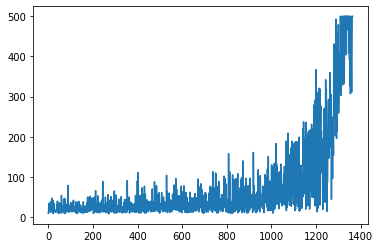

In [19]:
from matplotlib import pyplot as plt
plt.plot(episode_length_set)

In [24]:
# test our network
tf.reset_default_graph()
RL = DQN(actions_num = 2, gamma = 1,
         state_size = 4, epsilon_start = 1,
         learning_rate = 1e-3, epsilon_min = 0,
         replace_target_iter = 100, memory_size = 5000,
         epsilon_increment = None,)
# load saved parameters
RL.restore()
# run 100 trails and print how long can the agent hold the cart pole for each trail
for i in range(100):
  ############################
  # YOUR CODE STARTS HERE
    done=False
    hold =0
    new_state = env.reset()
    while not done:
        hold += 1
        action = RL.choose_action(new_state)
        state_next, reward, done, info = env.step(action)  
        new_state = state_next
    print(i,hold)
  # YOUR CODE ENDS HERE
  ############################
  

INFO:tensorflow:Restoring parameters from ./weights/DQN_model.ckpt
0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500
10 500
11 500
12 500
13 500
14 500
15 500
16 500
17 500
18 500
19 500
20 500
21 500
22 500
23 500
24 500
25 500
26 500
27 500
28 500
29 500
30 500
31 500
32 500
33 500
34 500
35 500
36 500
37 500
38 500
39 500
40 500
41 500
42 500
43 500
44 500
45 500
46 500
47 500
48 500
49 500
50 500
51 500
52 500
53 500
54 500
55 500
56 500
57 500
58 500
59 500
60 500
61 500
62 500
63 500
64 500
65 500
66 500
67 500
68 500
69 500
70 500
71 500
72 500
73 500
74 500
75 500
76 500
77 500
78 500
79 500
80 500
81 500
82 500
83 500
84 500
85 500
86 500
87 500
88 500
89 500
90 500
91 500
92 500
93 500
94 500
95 500
96 500
97 500
98 500
99 500


You may find that the episode length doesn't stably improve as more training time is given. You can read chapter 3.2 of this paper https://arxiv.org/pdf/1711.07478.pdf if you are interested.